In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [7]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Simulates RandomZoom
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # For translation
    transforms.ColorJitter(contrast=0.2),  # RandomContrast equivalent
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder("PlantVillage", transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for each dataset
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 64),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(64, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

model = CNNModel(n_classes=10).to(device)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%")


Epoch 1/8, Loss: 2.1882375468326716, Accuracy: 26.311680199875077%
Epoch 2/8, Loss: 2.300603026010273, Accuracy: 16.00562148657089%
Epoch 3/8, Loss: 2.2618586808703514, Accuracy: 19.925046845721425%
Epoch 4/8, Loss: 2.2628828547569397, Accuracy: 19.839163023110554%
Epoch 5/8, Loss: 2.2628048088369, Accuracy: 19.839163023110554%
Epoch 6/8, Loss: 2.262882855352242, Accuracy: 19.839163023110554%
Epoch 7/8, Loss: 2.262724627567439, Accuracy: 19.839163023110554%
Epoch 8/8, Loss: 2.254215531879001, Accuracy: 20.65115552779513%


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")


Test Accuracy: 20.474406991260924%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


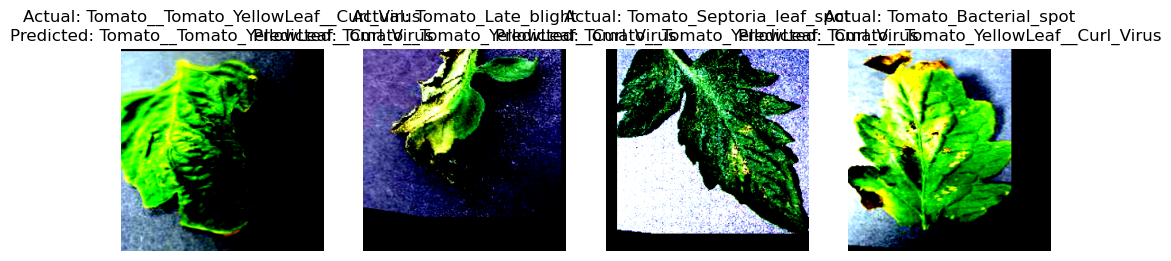

In [16]:
# Display 4 images from the test set and their predicted labels
def show_images(images, labels, predictions, class_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).cpu().numpy()
        label = class_names[labels[i]]
        pred = class_names[predictions[i]]
        ax.imshow(image)
        ax.set_title(f"Actual: {label}\nPredicted: {pred}")
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Show the first 4 images in the batch
show_images(images[:4], labels[:4], predictions[:4], dataset.classes)